## 모듈 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np # 데이터를 배열로 변환
import pandas as pd # CSV 등으로부터 데이터를 불러오고, 데이터프레임 형태
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # 상관관계
import seaborn as sns
from sklearn.model_selection import train_test_split # 데이터를 학습용과 테스트용으로 나눔
from sklearn.preprocessing import MinMaxScaler # 데이터를 정규화 학습력 높임
from sklearn.decomposition import PCA # PCA 분석
from tensorflow.keras.models import Sequential # LSTM 기반 모델을 정의하는데 필요
from tensorflow.keras.layers import LSTM, Dense, Dropout # LSTM 기반 모델을 정의하는데 필요
from tensorflow.keras.optimizers import Adam # 모델 학습 시 옵티마이저 / 자동으로 가중치(파라미터)를 조절하여 학습 최적화
from tensorflow.keras.callbacks import EarlyStopping # 과적합 방지용
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/문해프_미세먼지예측/강릉5년.csv')
print(type(data))  # <class 'pandas.DataFrame'> 확인

<class 'pandas.core.frame.DataFrame'>


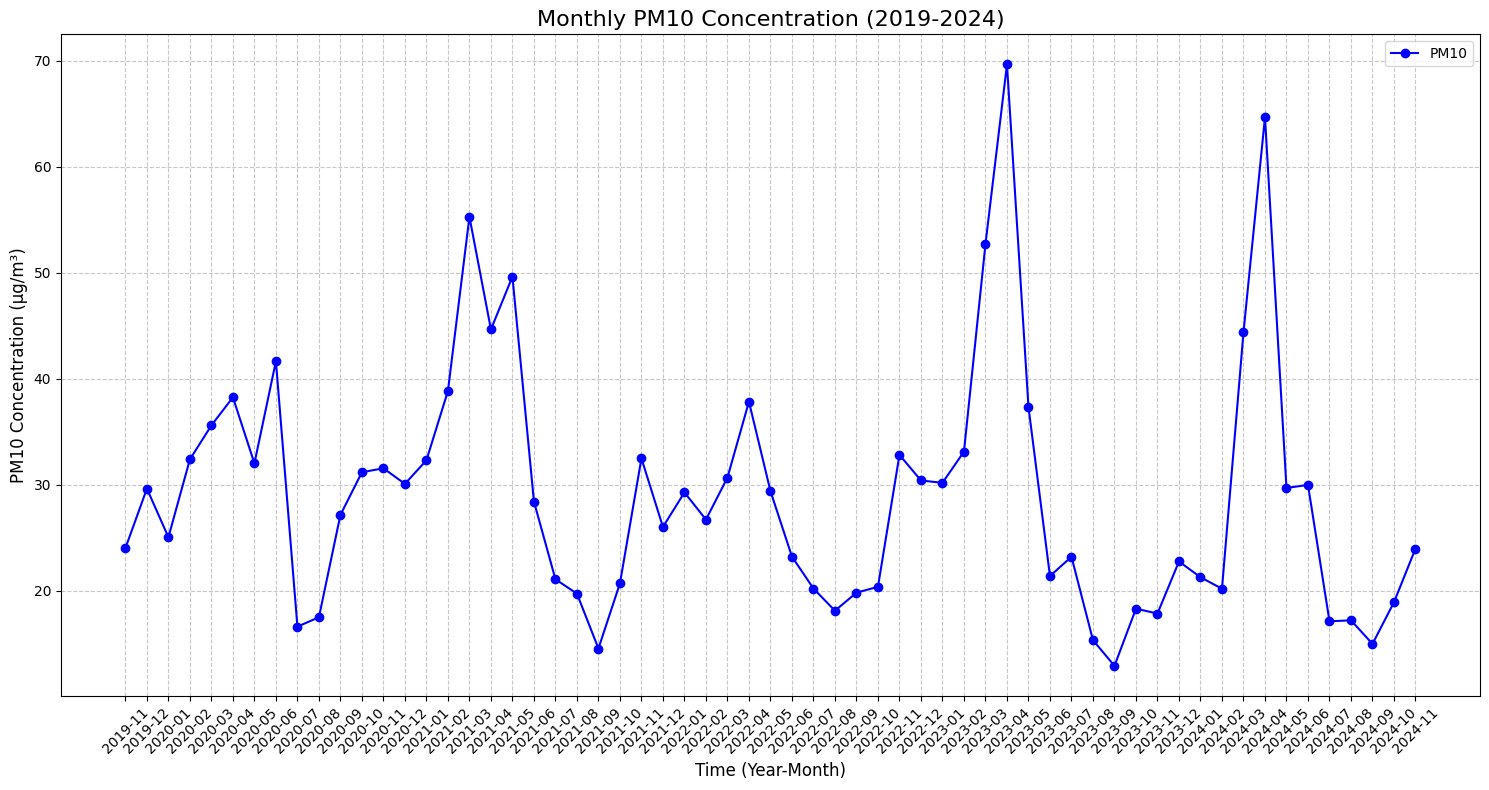

In [ ]:
# 데이터를 '연도-월'로 그룹화하여 PM10의 평균값 계산
data['DATE'] = pd.to_datetime(data['DATE'])  # DATE 열이 날짜 형식이어야 함
data['Year-Month'] = data['DATE'].dt.to_period('M')  # '연도-월'로 변환

data['PM10'] = data['PM10'].fillna(data['PM10'].rolling(window=window_size, min_periods=1, center=True).median())

monthly_avg_pm10 = data.groupby('Year-Month')['PM10'].mean()

# X축 라벨을 문자열로 변환
monthly_avg_pm10.index = monthly_avg_pm10.index.astype(str)

# 그래프 생성
plt.figure(figsize=(15, 8))
plt.plot(monthly_avg_pm10.index, monthly_avg_pm10.values, marker='o', color='b', label='PM10')

# 그래프 꾸미기
plt.title('Monthly PM10 Concentration (2019-2024)', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('PM10 Concentration (µg/m³)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)  # X축에 월을 추가하고 가독성 개선
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

In [ ]:
data.columns

Index(['DATE', 'AVE_TMP', 'MIN_TMP', 'MAX_TMP', 'PRECIP', 'MAX_WIND',
       'AVE_WIND', 'AVE_HUMIDQ', 'AVE_PRES', 'SUM_RADI', 'AVE_SURF_TMP',
       'SUM_EVAP_LARGE', 'SUM_EVAP_SMALL', 'PM10'],
      dtype='object')

In [ ]:
# PM10 칼럼의 통계값 계산
pm10_mean = data['PM10'].mean()      # 평균값
pm10_median = data['PM10'].median()  # 중앙값

# 결과 출력
print("PM10 칼럼의 평균값:", pm10_mean)
print("PM10 칼럼의 중앙값:", pm10_median)

PM10 칼럼의 평균값: 29.06949806949807
PM10 칼럼의 중앙값: 24.0


## 결측치 제거 계절패턴 고려한 30일기준

In [ ]:
data_time = data['DATE']  # DATE 따로 저장

# 날짜를 Datetime으로 변환 후 인덱스 설정
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# 계절적 패턴을 고려할 변수 리스트
seasonal_variables = ['AVE_TMP', 'MIN_TMP', 'MAX_TMP', 'MAX_WIND', 'AVE_WIND',
                      'AVE_HUMIDQ', 'AVE_PRES', 'SUM_RADI', 'AVE_SURF_TMP',
                      'SUM_EVAP_LARGE', 'SUM_EVAP_SMALL', 'PM10']

# 계절 이동 중앙값 대치 (30일 윈도우 기준)
window_size = 30  # 주기 설정
for var in seasonal_variables:
    data[var] = data[var].fillna(data[var].rolling(window=window_size, min_periods=1, center=True).median())

# PM10 열에 대한 결측치 처리
data['PM10'] = data['PM10'].fillna(data['PM10'].rolling(window=window_size, min_periods=1, center=True).median())

# 결측치가 모두 처리되었는지 확인
print(data.isnull().sum())

data_pm = data['PM10'] # PM10 따로 저장

AVE_TMP           0
MIN_TMP           0
MAX_TMP           0
PRECIP            0
MAX_WIND          0
AVE_WIND          0
AVE_HUMIDQ        0
AVE_PRES          0
SUM_RADI          0
AVE_SURF_TMP      0
SUM_EVAP_LARGE    0
SUM_EVAP_SMALL    0
PM10              0
dtype: int64


In [ ]:
data_pm

,PM10
DATE,
2019-11-25,24.0
2019-11-26,24.0
2019-11-27,24.0
2019-11-28,24.0
2019-11-29,24.0
...,...
2024-11-21,45.0
2024-11-22,32.0
2024-11-23,12.0


## 상관계수 확인

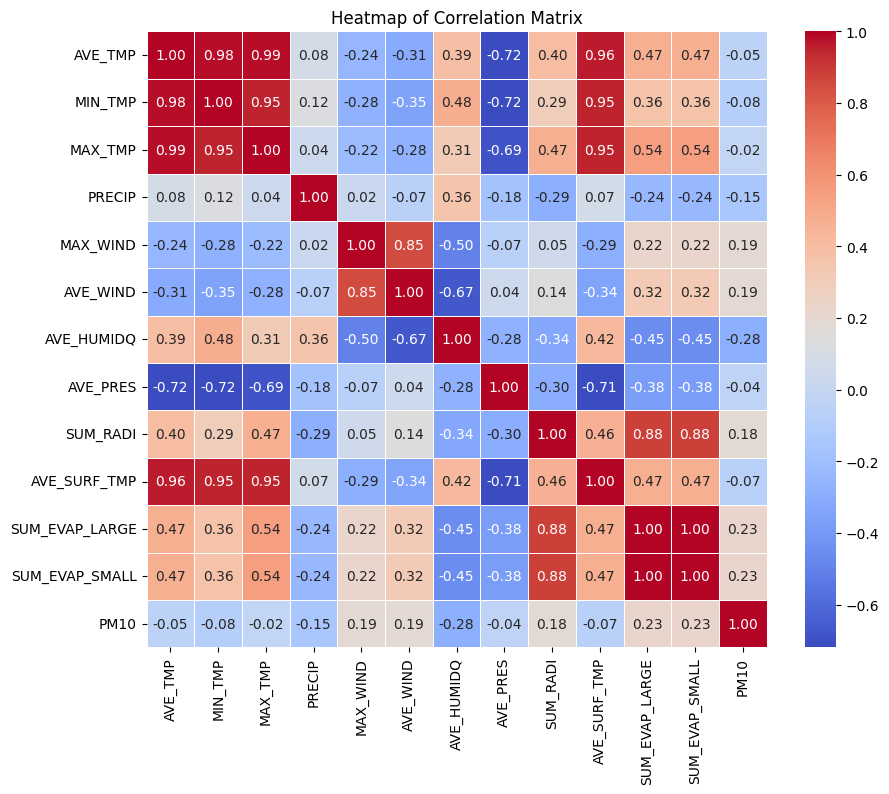

In [ ]:
# 데이터 불러오기 (예시로 CSV 파일을 불러옴)

#data = pd.read_csv('/content/drive/MyDrive/문해프_미세먼지예측/강릉5년.csv')  # 파일 경로에 맞게 변경

# 시간데이터 제거
temp = data.iloc[:, 0:]
# 상관계수 계산
correlation_matrix = temp.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))  # 히트맵 크기 조정
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# 타이틀 설정
plt.title('Heatmap of Correlation Matrix')

# 그래프 출력
plt.show()

In [ ]:
print(correlation_matrix.round(2))

                AVE_TMP  MIN_TMP  MAX_TMP  PRECIP  MAX_WIND  AVE_WIND  \
AVE_TMP            1.00     0.98     0.99    0.08     -0.24     -0.31   
MIN_TMP            0.98     1.00     0.95    0.12     -0.28     -0.35   
MAX_TMP            0.99     0.95     1.00    0.04     -0.22     -0.28   
PRECIP             0.08     0.12     0.04    1.00      0.02     -0.07   
MAX_WIND          -0.24    -0.28    -0.22    0.02      1.00      0.85   
AVE_WIND          -0.31    -0.35    -0.28   -0.07      0.85      1.00   
AVE_HUMIDQ         0.39     0.48     0.31    0.36     -0.50     -0.67   
AVE_PRES          -0.72    -0.72    -0.69   -0.18     -0.07      0.04   
SUM_RADI           0.40     0.29     0.47   -0.29      0.05      0.14   
AVE_SURF_TMP       0.96     0.95     0.95    0.07     -0.29     -0.34   
SUM_EVAP_LARGE     0.47     0.36     0.54   -0.24      0.22      0.32   
SUM_EVAP_SMALL     0.47     0.36     0.54   -0.24      0.22      0.32   
PM10              -0.05    -0.08    -0.02   -0.15  

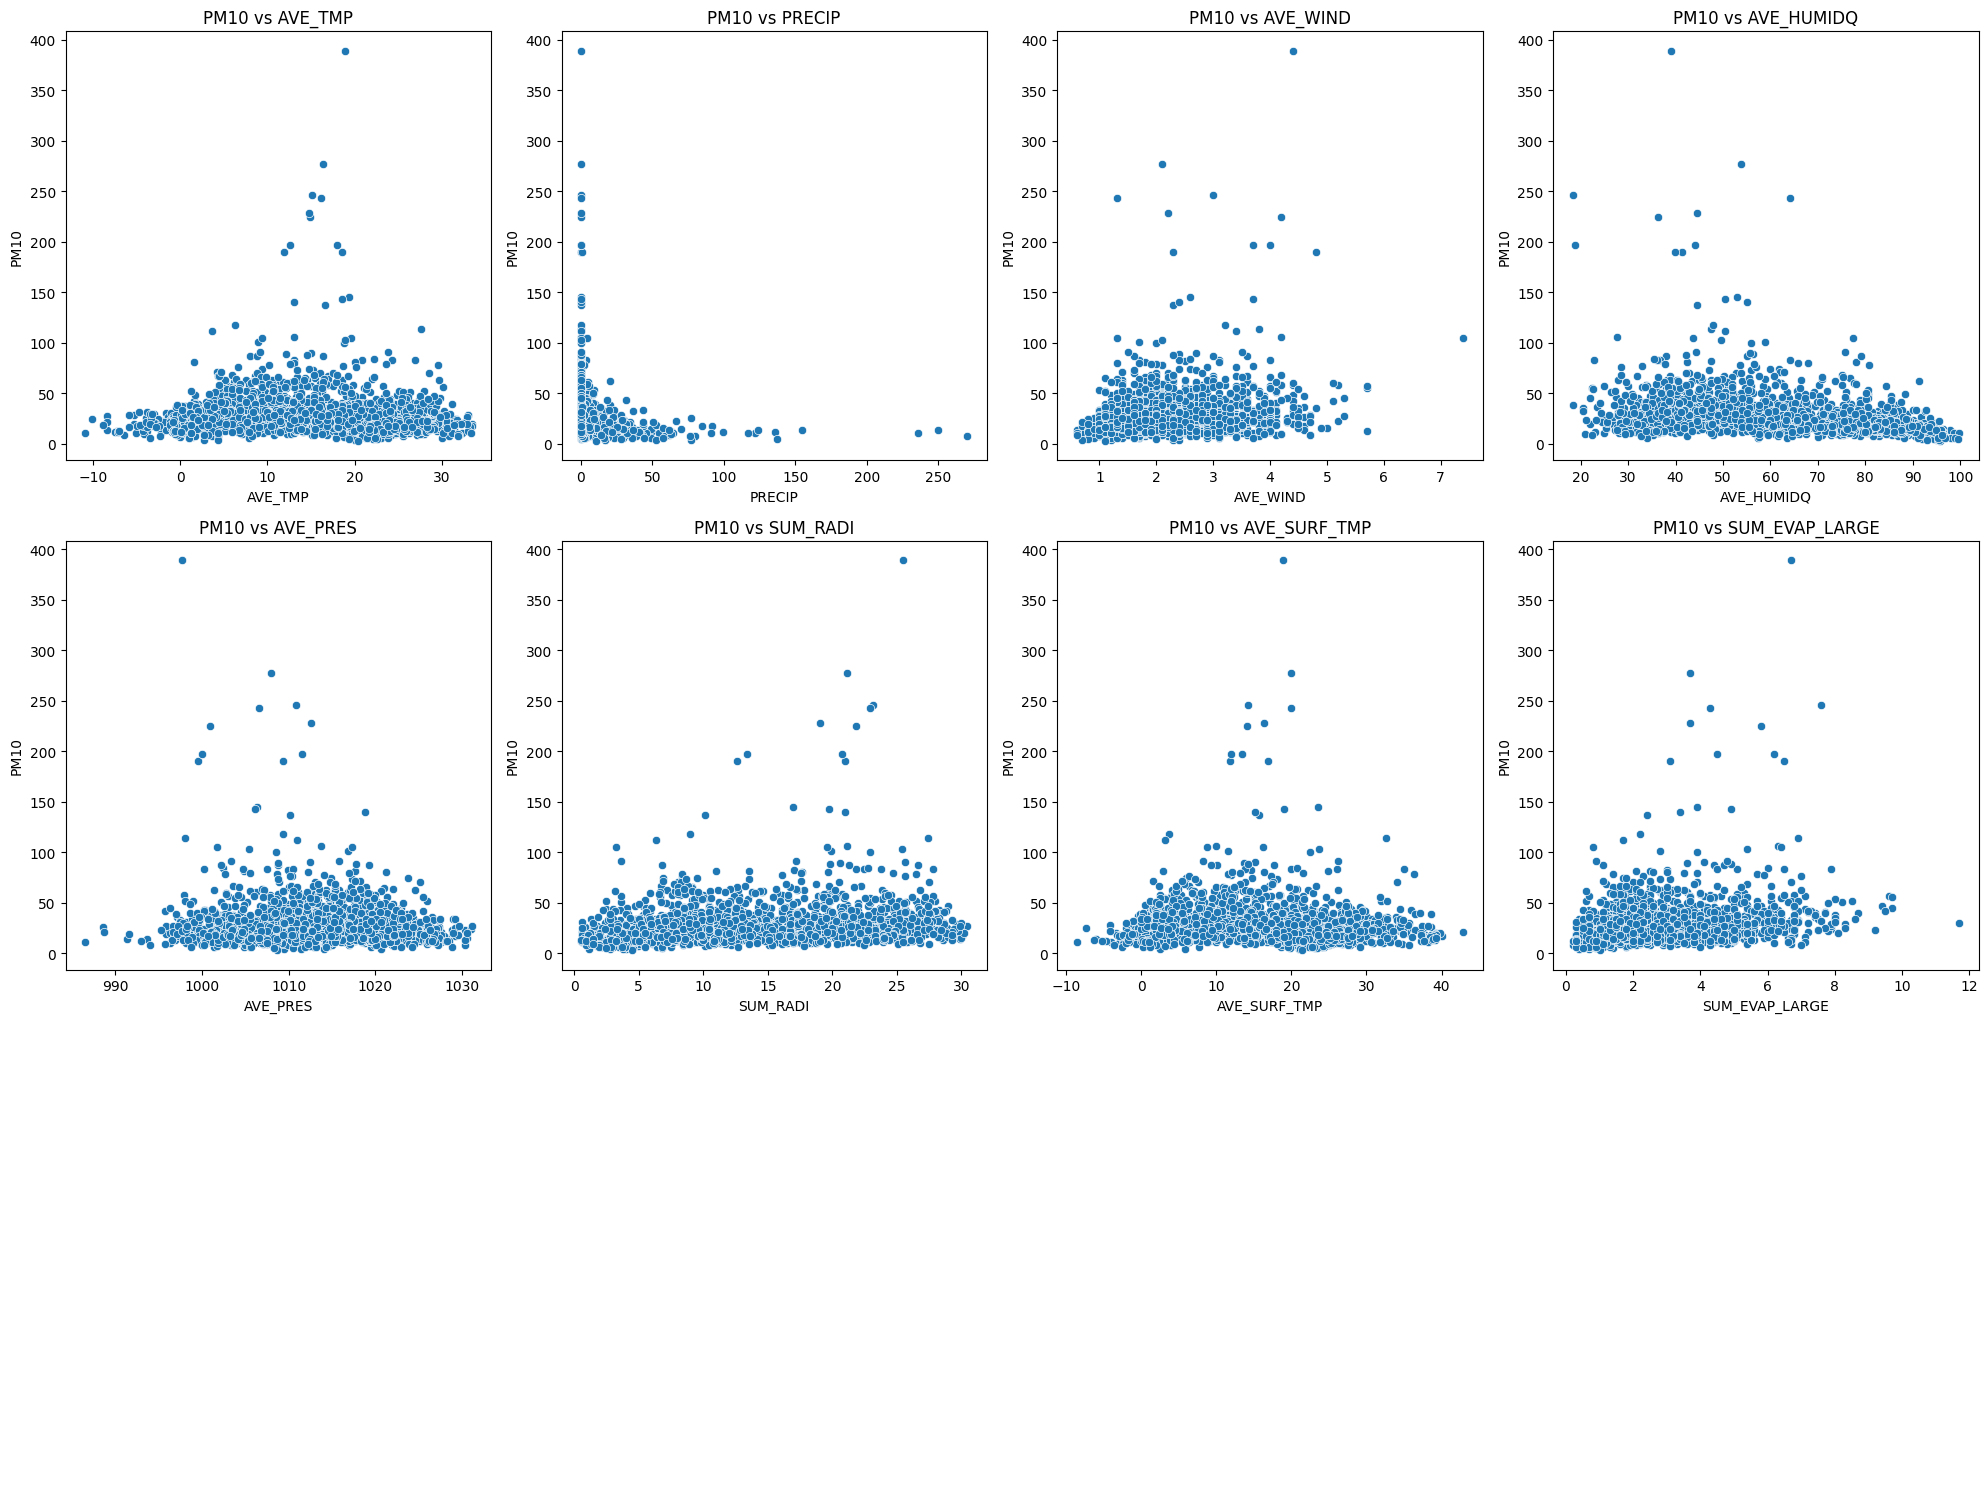

In [ ]:
# 새 독립변수 리스트
data.columns = data.columns.str.strip()  # 공백 제거

independent_vars = [
    "AVE_TMP", 'PRECIP',
    'AVE_WIND', 'AVE_HUMIDQ',
    'AVE_PRES', 'SUM_RADI', 'AVE_SURF_TMP',
    'SUM_EVAP_LARGE'
]

# 그래프의 행과 열 설정 (3x4 형태로 배치)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# 각 독립변수와 종속변수(PM10) 간의 관계 시각화
for i, var in enumerate(independent_vars):
    sns.scatterplot(x=data[var], y=data['PM10'], ax=axes[i])
    axes[i].set_title(f"PM10 vs {var}")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("PM10")

# 남는 subplot 숨기기 (필요 없는 빈 칸 제거)
for j in range(len(independent_vars), len(axes)):
    axes[j].axis('off')

# 그래프 간격 조정
plt.tight_layout()
plt.show()

In [ ]:
# 데이터를 '연도-월'로 그룹화하여 PM10의 평균값 계산
data['DATE'] = pd.to_datetime(data['DATE'])  # DATE 열이 날짜 형식이어야 함
data['Year-Month'] = data['DATE'].dt.to_period('M')  # '연도-월'로 변환

monthly_avg_pm10 = data.groupby('Year-Month')['PM10'].mean()

# 그래프 생성
plt.figure(figsize=(15, 8))
monthly_avg_pm10.plot(kind='line', marker='o', color='b', label='PM10')

# 그래프 꾸미기
plt.title('Monthly PM10 Concentration (2019-2024)', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('PM10 Concentration (µg/m³)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()

KeyError: 'DATE'

In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# 각 그룹의 변수들을 데이터프레임으로 묶기
group1 = data[['AVE_TMP', 'MIN_TMP', 'MAX_TMP', 'AVE_SURF_TMP']]
group2 = data[['MAX_WIND', 'AVE_WIND']]
group3 = data[['PRECIP', 'SUM_RADI', 'SUM_EVAP_LARGE', 'SUM_EVAP_SMALL']]
group4 = data[['AVE_PRES']]

# 데이터를 표준화 (PCA 전에 반드시 필요)
scaler = StandardScaler()

In [ ]:
# 각 그룹에 대해 표준화 적용
group1_scaled = scaler.fit_transform(group1)
group2_scaled = scaler.fit_transform(group2)
group3_scaled = scaler.fit_transform(group3)
group4_scaled = scaler.fit_transform(group4)

# 표준화 후 NaN 값이 있는지 확인
print("NaN values in group1_scaled:", np.isnan(group1_scaled).sum())
print("NaN values in group2_scaled:", np.isnan(group2_scaled).sum())
print("NaN values in group3_scaled:", np.isnan(group3_scaled).sum())
print("NaN values in group4_scaled:", np.isnan(group4_scaled).sum())

NaN values in group1_scaled: 0
NaN values in group2_scaled: 0
NaN values in group3_scaled: 0
NaN values in group4_scaled: 0


In [ ]:
# PCA 분석
pca_group1 = PCA(n_components=2)
pca_group2 = PCA(n_components=2)
pca_group3 = PCA(n_components=2)
pca_group4 = PCA(n_components=1)

# 주성분 추출
pca_group1_result = pca_group1.fit_transform(group1_scaled)
pca_group2_result = pca_group2.fit_transform(group2_scaled)
pca_group3_result = pca_group3.fit_transform(group3_scaled)
pca_group4_result = pca_group4.fit_transform(group4_scaled)

# 주성분 설명력 출력
print("Group 1 Explained Variance Ratio:", pca_group1.explained_variance_ratio_)
print("Group 2 Explained Variance Ratio:", pca_group2.explained_variance_ratio_)
print("Group 3 Explained Variance Ratio:", pca_group3.explained_variance_ratio_)
print("Group 4 Explained Variance Ratio:", pca_group4.explained_variance_ratio_)

# 변환된 데이터를 확인
group1_pca_df = pd.DataFrame(pca_group1_result, columns=['PC1', 'PC2'])
group2_pca_df = pd.DataFrame(pca_group2_result, columns=['PC1', 'PC2'])
group3_pca_df = pd.DataFrame(pca_group3_result, columns=['PC1', 'PC2'])
group4_pca_df = pd.DataFrame(pca_group4_result, columns=['PC1'])

# 결과 결합
final_pca_data = pd.concat([group1_pca_df, group2_pca_df, group3_pca_df, group4_pca_df], axis=1)

print(final_pca_data.head())

Group 1 Explained Variance Ratio: [0.97227947 0.01352757]
Group 2 Explained Variance Ratio: [0.92303949 0.07696051]
Group 3 Explained Variance Ratio: [0.7365381  0.22528785]
Group 4 Explained Variance Ratio: [1.]
        PC1       PC2       PC1       PC2       PC1       PC2       PC1
0 -1.412716  0.085906  0.452862  1.363090 -2.930699  1.000858  1.766380
1 -1.535607  0.024473 -0.206150  0.042357 -0.807985 -0.461877  1.689552
2 -1.458284 -0.102646  0.584520  0.005876 -1.519697  0.450084  1.356634
3 -2.239404  0.118993 -1.657637  0.079741 -2.683190  0.890158  1.907230
4 -2.176928 -0.071266  0.207425 -0.371218 -1.603953 -0.623386  1.881621


In [ ]:
# 변환된 데이터를 확인 (열 이름 수정)
group1_pca_df = pd.DataFrame(pca_group1_result, columns=['Group1_PC1', 'Group1_PC2'])
group2_pca_df = pd.DataFrame(pca_group2_result, columns=['Group2_PC1', 'Group2_PC2'])
group3_pca_df = pd.DataFrame(pca_group3_result, columns=['Group3_PC1', 'Group3_PC2'])
group4_pca_df = pd.DataFrame(pca_group4_result, columns=['Group4_PC1'])

# 결과 결합 (열 이름 중복 방지)
final_pca_data = pd.concat([group1_pca_df, group2_pca_df, group3_pca_df, group4_pca_df], axis=1)

print(final_pca_data.head())

   Group1_PC1  Group1_PC2  Group2_PC1  Group2_PC2  Group3_PC1  Group3_PC2  \
0   -1.412716    0.085906    0.452862    1.363090   -2.930699    1.000858   
1   -1.535607    0.024473   -0.206150    0.042357   -0.807985   -0.461877   
2   -1.458284   -0.102646    0.584520    0.005876   -1.519697    0.450084   
3   -2.239404    0.118993   -1.657637    0.079741   -2.683190    0.890158   
4   -2.176928   -0.071266    0.207425   -0.371218   -1.603953   -0.623386   

   Group4_PC1  
0    1.766380  
1    1.689552  
2    1.356634  
3    1.907230  
4    1.881621  


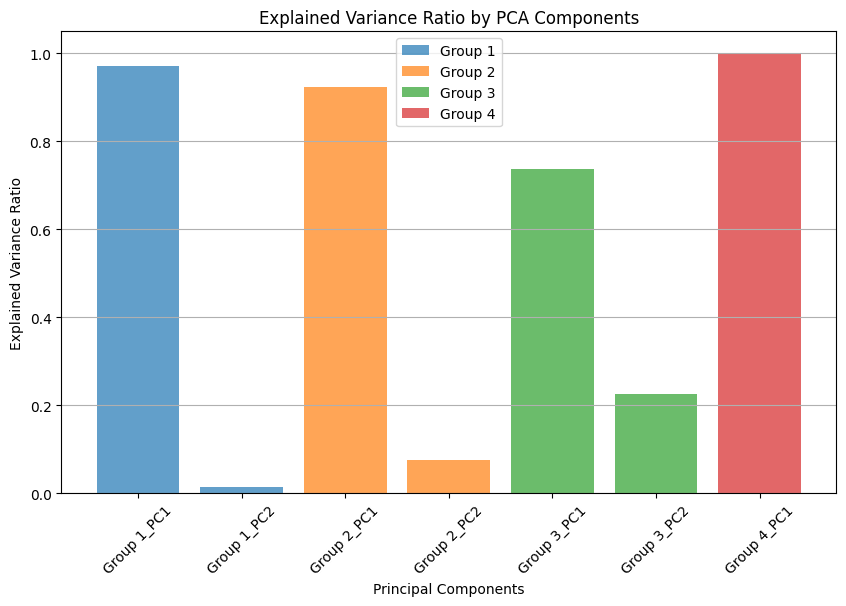

In [ ]:
# 설명 분산 비율 (Variance Ratio) 데이터
explained_variance_ratios = {
    "Group 1": pca_group1.explained_variance_ratio_,
    "Group 2": pca_group2.explained_variance_ratio_,
    "Group 3": pca_group3.explained_variance_ratio_,
    "Group 4": pca_group4.explained_variance_ratio_,
}

# 막대그래프 시각화
plt.figure(figsize=(10, 6))
for i, (group_name, ratios) in enumerate(explained_variance_ratios.items()):
    plt.bar([f"{group_name}_PC{i+1}" for i in range(len(ratios))], ratios, alpha=0.7, label=group_name)

plt.title("Explained Variance Ratio by PCA Components")
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Components")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
data_pm

,PM10
DATE,
2019-11-25,24.0
2019-11-26,24.0
2019-11-27,24.0
2019-11-28,24.0
2019-11-29,24.0
...,...
2024-11-21,45.0
2024-11-22,32.0
2024-11-23,12.0


In [ ]:
final_pca_data

,Group1_PC1,Group1_PC2,Group2_PC1,Group2_PC2,Group3_PC1,Group3_PC2,Group4_PC1
0,-1.412716,0.085906,0.452862,1.363090,-2.930699,1.000858,1.766380
1,-1.535607,0.024473,-0.206150,0.042357,-0.807985,-0.461877,1.689552
2,-1.458284,-0.102646,0.584520,0.005876,-1.519697,0.450084,1.356634
3,-2.239404,0.118993,-1.657637,0.079741,-2.683190,0.890158,1.907230
4,-2.176928,-0.071266,0.207425,-0.371218,-1.603953,-0.623386,1.881621
...,...,...,...,...,...,...,...
1823,-0.961852,-0.336563,-0.005142,-0.252925,-1.008985,-0.482164,0.332270
1824,-1.496212,-0.320364,0.513363,0.265580,-1.341317,-0.557902,0.895670
1825,-1.903421,-0.074279,-0.937221,-0.357854,-2.011983,-0.657613,1.753575
1826,-1.526795,-0.130613,-0.335099,-0.582882,-0.807147,-0.453284,1.791989


In [ ]:
final_pca_data['DATE'] = data_time

# final_pca_data의 'DATE' 컬럼을 인덱스로 설정
final_pca_data.set_index('DATE', inplace=True)

In [ ]:
# 결과 확인
data_pm.index = pd.to_datetime(data_pm.index)
final_pca_data.index = pd.to_datetime(final_pca_data.index)
final_pca_data

,Group1_PC1,Group1_PC2,Group2_PC1,Group2_PC2,Group3_PC1,Group3_PC2,Group4_PC1
DATE,,,,,,,
2019-11-25,-1.412716,0.085906,0.452862,1.363090,-2.930699,1.000858,1.766380
2019-11-26,-1.535607,0.024473,-0.206150,0.042357,-0.807985,-0.461877,1.689552
2019-11-27,-1.458284,-0.102646,0.584520,0.005876,-1.519697,0.450084,1.356634
2019-11-28,-2.239404,0.118993,-1.657637,0.079741,-2.683190,0.890158,1.907230
2019-11-29,-2.176928,-0.071266,0.207425,-0.371218,-1.603953,-0.623386,1.881621
...,...,...,...,...,...,...,...
2024-11-21,-0.961852,-0.336563,-0.005142,-0.252925,-1.008985,-0.482164,0.332270
2024-11-22,-1.496212,-0.320364,0.513363,0.265580,-1.341317,-0.557902,0.895670
2024-11-23,-1.903421,-0.074279,-0.937221,-0.357854,-2.011983,-0.657613,1.753575


In [ ]:
# 인덱스 형식 일치 시키기
data_pm.index = pd.to_datetime(data_pm.index)
final_pca_data.index = pd.to_datetime(final_pca_data.index)

# 'data_pm'이 이미 'DATE'를 인덱스로 설정하고 있다고 가정
final_pca_data = final_pca_data.join(data_pm, how='left')

data = final_pca_data

# 결과 확인
print(final_pca_data.head())

            Group1_PC1  Group1_PC2  Group2_PC1  Group2_PC2  Group3_PC1  \
DATE                                                                     
2019-11-25   -1.412716    0.085906    0.452862    1.363090   -2.930699   
2019-11-26   -1.535607    0.024473   -0.206150    0.042357   -0.807985   
2019-11-27   -1.458284   -0.102646    0.584520    0.005876   -1.519697   
2019-11-28   -2.239404    0.118993   -1.657637    0.079741   -2.683190   
2019-11-29   -2.176928   -0.071266    0.207425   -0.371218   -1.603953   

            Group3_PC2  Group4_PC1  PM10  
DATE                                      
2019-11-25    1.000858    1.766380  24.0  
2019-11-26   -0.461877    1.689552  24.0  
2019-11-27    0.450084    1.356634  24.0  
2019-11-28    0.890158    1.907230  24.0  
2019-11-29   -0.623386    1.881621  24.0  


In [ ]:
data

,Group1_PC1,Group1_PC2,Group2_PC1,Group2_PC2,Group3_PC1,Group3_PC2,Group4_PC1,PM10
DATE,,,,,,,,
2019-11-25,-1.412716,0.085906,0.452862,1.363090,-2.930699,1.000858,1.766380,24.0
2019-11-26,-1.535607,0.024473,-0.206150,0.042357,-0.807985,-0.461877,1.689552,24.0
2019-11-27,-1.458284,-0.102646,0.584520,0.005876,-1.519697,0.450084,1.356634,24.0
2019-11-28,-2.239404,0.118993,-1.657637,0.079741,-2.683190,0.890158,1.907230,24.0
2019-11-29,-2.176928,-0.071266,0.207425,-0.371218,-1.603953,-0.623386,1.881621,24.0
...,...,...,...,...,...,...,...,...
2024-11-21,-0.961852,-0.336563,-0.005142,-0.252925,-1.008985,-0.482164,0.332270,45.0
2024-11-22,-1.496212,-0.320364,0.513363,0.265580,-1.341317,-0.557902,0.895670,32.0
2024-11-23,-1.903421,-0.074279,-0.937221,-0.357854,-2.011983,-0.657613,1.753575,12.0


## 데이터 전처리

In [ ]:
# 데이터 불러오기
#data = pd.read_csv('/content/drive/MyDrive/문해프_미세먼지예측/강릉5년.csv')

#print(data.head())

# 시간 지연 추가
#data['AVE_TMP'] = data['AVE_TMP'].shift(1)
#data['MIN_TMP'] = data['MIN_TMP'].shift(1)
#data['MAX_TMP'] = data['MAX_TMP'].shift(6)
#data['AVE_HUMIDQ'] = data['AVE_HUMIDQ'].shift(1)
#data['AVE_WIND'] = data['AVE_WIND'].shift(1)  # 평균 풍속
#data['MAX_WIND'] = data['MAX_WIND'].shift(3)  # 최대 풍속
#data['PRECIP'] = data['PRECIP'].shift(2)      # 강수량
#data['AVE_PRES'] = data['AVE_PRES'].shift(1)  # 평균 현지기압
#data['SUM_RADI'] = data['SUM_RADI'].shift(2)  # 합계 일사량
#data['AVE_SURF_TMP'] = data['AVE_SURF_TMP'].shift(1)  # 평균 지면온도
#data['SUM_EVAP_LARGE'] = data['SUM_EVAP_LARGE'].shift(2)  # 대형 증발량
#data['SUM_EVAP_SMALL'] = data['SUM_EVAP_SMALL'].shift(1)  # 소형 증발량

# 독립, 종속 데이터셋 분할
X = data[['Group1_PC1', 'Group1_PC2', 'Group2_PC1', 'Group2_PC2', 'Group3_PC1', 'Group3_PC2', 'Group4_PC1']]
y = data['PM10']

# 전체 데이터 개수
total_data_count = len(data)

# 테스트 셋을 24개월로 설정 (여기서는 전체 데이터 개수를 알아야 정확한 비율을 계산할 수 있습니다)
test_size_ratio = 24 / total_data_count

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_ratio, random_state=42)

# 데이터 정규화
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM에 맞게 데이터 형태 변환
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [ ]:
#LSTM
# 모델을 생성하는 함수 정의
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('first_layer_units', min_value=50, max_value=200, step=50),
                   return_sequences=True,
                   input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # 추가 LSTM 레이어를 조건부로 추가
    if hp.Boolean('second_layer'):
        model.add(LSTM(units=hp.Int('second_layer_units', min_value=50, max_value=200, step=50)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# 튜너 설정
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# 튜닝 시작
tuner.search(x=X_train_scaled, y=y_train, epochs=10, validation_split=0.2)

# 최적의 모델 구성과 하이퍼파라미터 출력
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 01m 07s]
val_loss: 364.44373575846356

Best val_loss So Far: 335.6303405761719
Total elapsed time: 00h 08m 52s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 150)              │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 150)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 200)                 │         280,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 372,201 (1.42 MB)

 Trainable params: 372,201 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 생성
#model = Sequential([
#    LSTM(LSTM(100, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)),
#    Dropout(0.22),
#    LSTM(100),
#    Dropout(0.22),
#    Dense(1)
#])

# 모델 컴파일
#model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
#LSTM
# 모델 생성
model = Sequential([
    # 첫 번째 LSTM 레이어
    LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)),  # 50 유닛 사용
    # 두 번째 LSTM 레이어
    LSTM(50, return_sequences=True),  # 50 유닛 사용, 연속 출력 유지
    Dropout(0.22),
    # 출력 레이어
    Dense(1)  # 각 시퀀스 스텝별로 1개의 출력
])
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 학습
#history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=128, validation_split=0.1, callbacks=[early_stopping], verbose=1)
history = model.fit(X_train_scaled, y_train, epochs=800, batch_size=128, callbacks=[early_stopping], verbose=1)

Epoch 1/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1299.9011
Epoch 2/800
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 798.5229

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 749.4716
Epoch 3/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 468.4372
Epoch 4/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 648.9619
Epoch 5/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 653.4590
Epoch 6/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 464.8449
Epoch 7/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 456.1844
Epoch 8/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 532.8031
Epoch 9/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 510.2216
Epoch 10/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 510.7299
Epoch 11/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 540.8641
Epoch 12/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 440.3053
Epoch 13/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 514.1625
Epoch 14/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 648.8060
Epoch 15/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 647.2435
Epoch 16/800
15/15 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#LSTM
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import r2_score
import numpy as np

class R2ThresholdCallback(Callback):
    def __init__(self, validation_data, threshold=0.8):
        super().__init__()
        self.validation_data = validation_data
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        r2 = r2_score(y_val, y_pred[:, -1])  # 마지막 타임스텝의 예측만 사용
        if r2 > self.threshold:
            print(f"\nReached R²={r2:.4f} > {self.threshold}, stopping training.")
            self.model.stop_training = True

# 모델 훈련에 콜백 사용
model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=500,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
               R2ThresholdCallback(validation_data=(X_test_scaled, y_test))],
    verbose=1
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 436.8308 - val_loss: 226.3958
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 524.8061 - val_loss: 297.5518
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 436.8227 - val_loss: 260.4886
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 498.5229 - val_loss: 314.8040
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 673.5410 - val_loss: 276.0264
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 514.3330 - val_loss: 277.8672
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 581.9913 - val_loss: 245.4580
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 520.3

In [ ]:
# R² 콜백 정의 / 수정 코드
class R2Callback(Callback):
    def __init__(self, train_data, validation_data):
        super().__init__()
        self.train_data = train_data
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # 학습 데이터에서 R² 계산
        train_pred = self.model.predict(self.train_data[0])
        train_r2 = r2_score(self.train_data[1], train_pred)

        # 검증 데이터에서 R² 계산
        val_pred = self.model.predict(self.validation_data[0])
        val_r2 = r2_score(self.validation_data[1], val_pred)

        print(f"Epoch {epoch + 1}: Train R² = {train_r2:.4f}, Val R² = {val_r2:.4f}")
        return

# X_train_scaled와 X_test_scaled가 2D인 경우 3D로 변환
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)  # (samples, time steps, 1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)    # (samples, time steps, 1)

# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    tf.keras.layers.Dropout(0.22),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.22),
    tf.keras.layers.Dense(1)
])

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# 조기 종료 콜백 정의
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# 모델 훈련
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=500,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, R2Callback(train_data=(X_train_scaled, y_train), validation_data=(X_test_scaled, y_test))],
    verbose=1
)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1: Train R² = -0.0017, Val R² = -0.1804
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 694.1892 - val_loss: 339.8615
Epoch 2/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 2: Train R² = -0.0010, Val R² = -0.1696
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 526.0871 - val_loss: 336.7604
Epoch 3/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 3: Train R² = -0.0034, Val R² = -0.0837
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 620.8355 - val_loss: 312.0275
Epoch 4/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 4: Train R² = -0.0003, Val R² = -0.1537
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 491.2569 - val_loss: 332.1735
Epoch 5/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 5: Train R² = -0.0056, Val R² = -0.2211
57/57 ━━━━━━━━━━━━━━━━━

In [ ]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#predictions = model.predict(X_test_scaled)

# 예측 결과의 차원 확인 및 변환
# predictions.shape 예상 출력: (샘플 수, 시퀀스 길이, 출력 차원)
# 마지막 타임스텝의 값을 선택하여 차원을 줄임
#predictions = predictions[:, -1, 0]  # 가정: 각 샘플의 마지막 타임스텝, 첫 번째 출력 차원

# 평균 절대 오차(MAE) 계산
#mae = mean_absolute_error(y_test, predictions)
#print("평균 절대 오차 (MAE):", mae)

# 평균 제곱근 오차(RMSE) 계산
#rmse = mean_squared_error(y_test, predictions, squared=False)
#print("평균 제곱근 오차 (RMSE):", rmse)

# 결정 계수 (R²) 값 계산
#r_squared = r2_score(y_test, predictions)
#print("결정 계수 (R²):", r_squared)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
predictions = model.predict(X_test_scaled)

# 예측 결과 출력
print(predictions.shape)

# 평균 절대 오차(MAE) 계산
mae = mean_absolute_error(y_test, predictions)
print("평균 절대 오차 (MAE):", mae)

# 평균 제곱근 오차 (RMSE) 계산
rmse = mean_squared_error(y_test, predictions, squared=False)  # squared=False로 설정
print("평균 제곱근 오차 (RMSE):", rmse)

# 결정 계수 (R²) 값 계산
r_squared = r2_score(y_test, predictions)
print("결정 계수 (R²):", r_squared)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(24, 1)
평균 절대 오차 (MAE): 13.551025867462158
평균 제곱근 오차 (RMSE): 17.66429916504527
결정 계수 (R²): -0.08374391444462614


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# 예측 값이 3D 배열인 경우 (samples, time steps, features)
if len(predictions.shape) == 3:
    # 마지막 타임스텝만 선택하여 (samples, features) 형태로 만들기
    predictions = predictions[:, -1, 0]  # (samples,) 형태로 변경

# 예측값이 2D 배열인 경우 (samples, features)
elif len(predictions.shape) == 2:
    predictions = predictions[:, 0]  # 첫 번째 특징만 사용하여 (samples,) 형태로 변경

# 예측값 역 정규화 (2D로 변환 후 역 정규화)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # 예측값 역 정규화

# 실제값 역 정규화
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))  # 실제값 역 정규화

# 성능 평가 지표 출력
mae = mean_absolute_error(y_test_original, predictions)
rmse = mean_squared_error(y_test_original, predictions, squared=False)
r_squared = r2_score(y_test_original, predictions)

print("평균 절대 오차 (MAE):", mae)
print("평균 제곱근 오차 (RMSE):", rmse)
print("결정 계수 (R²):", r_squared)

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 실제값과 예측값 비교
plt.plot(np.arange(len(y_test_original)), y_test_original, label="실제값 (True Values)", color="blue", linewidth=2)
plt.plot(np.arange(len(predictions)), predictions, label="예측값 (Predictions)", color="orange", linestyle="--", linewidth=2)

# 그래프 꾸미기
plt.title("PM10 예측 결과 비교", fontsize=16)
plt.xlabel("샘플 번호", fontsize=14)
plt.ylabel("PM10 농도", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# 성능 지표 텍스트 추가
text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r_squared:.4f}"
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# 그래프 출력
plt.show()


ValueError: non-broadcastable output operand with shape (24,1) doesn't match the broadcast shape (24,7)